In [1]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D,Dropout

In [2]:
path = "cat_dog_2/"

In [3]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory(f"{path}/training_set",
                                                       target_size = (128,128),
                                                       batch_size=8,
                                                       class_mode="binary",
                                                       shuffle=True)

Found 4000 images belonging to 2 classes.


In [4]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(f"{path}/test_set",
                                                       target_size = (128,128),
                                                       batch_size=1,
                                                       class_mode="binary",
                                                       shuffle=False)

Found 1000 images belonging to 2 classes.


#### Pre-trained Network: ResNet

In [5]:
mobilenet = tf.keras.applications.MobileNetV2(weights="imagenet",
                                          include_top=False,
                                          input_tensor = Input(shape=(128,128,3)))
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [6]:
# for layer in resnet50.layers:
#     layer.trainable=False

In [27]:
model = mobilenet.output
model = GlobalAveragePooling2D()(model)
model = Dense(units=100,activation="relu")(model)
model = Dropout(rate=0.2)(model)
model = Dense(units=100,activation="relu")(model)
model = Dropout(rate=0.2)(model)
model = Dense(1,activation="sigmoid")(model)

In [28]:
cnn = Model(inputs=mobilenet.input,outputs=model)
cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [29]:
cnn.compile(optimizer="Adam",
            loss="binary_crossentropy",
            metrics=["accuracy"])

In [10]:
h = cnn.fit(train_dataset,epochs=3)

Epoch 1/3
500/500 [==============================] - 123s 239ms/step - loss: 0.5073 - accuracy: 0.7772
Epoch 2/3
500/500 [==============================] - 120s 240ms/step - loss: 0.3962 - accuracy: 0.8363
Epoch 3/3
500/500 [==============================] - 122s 244ms/step - loss: 0.3338 - accuracy: 0.8777


In [11]:
predictions = cnn.predict(test_dataset)
predictions = predictions > 0.5

In [12]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

accuracy_score(test_dataset.classes,predictions)

0.5

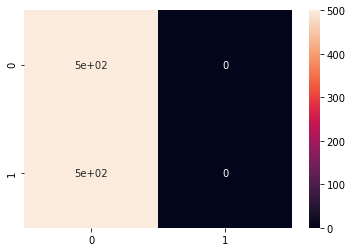

In [13]:
cm = confusion_matrix(test_dataset.classes,predictions)
sns.heatmap(cm,annot=True);

In [14]:
# print(classification_report(test_dataset.classes,predictions))

In [30]:
fine_tuning_at = 100
for layer in mobilenet.layers[:fine_tuning_at]:
    layer.trainable = False

In [31]:
cnn.compile(optimizer="Adam",
            loss="binary_crossentropy",
            metrics=["accuracy"])

In [32]:
h = cnn.fit(train_dataset,epochs=20)

Epoch 1/20
500/500 [==============================] - 47s 88ms/step - loss: 0.2315 - accuracy: 0.9140
Epoch 2/20
500/500 [==============================] - 45s 90ms/step - loss: 0.2196 - accuracy: 0.9210
Epoch 3/20
500/500 [==============================] - 53s 105ms/step - loss: 0.2173 - accuracy: 0.9225
Epoch 4/20
500/500 [==============================] - 51s 102ms/step - loss: 0.1973 - accuracy: 0.9277
Epoch 5/20
500/500 [==============================] - 49s 99ms/step - loss: 0.1812 - accuracy: 0.9310
Epoch 6/20
500/500 [==============================] - 50s 99ms/step - loss: 0.1757 - accuracy: 0.9352
Epoch 7/20
500/500 [==============================] - 50s 100ms/step - loss: 0.1675 - accuracy: 0.9410
Epoch 8/20
500/500 [==============================] - 52s 104ms/step - loss: 0.1634 - accuracy: 0.9398
Epoch 9/20
500/500 [==============================] - 50s 99ms/step - loss: 0.1508 - accuracy: 0.9433
Epoch 10/20
500/500 [==============================] - 50s 101ms/step - loss: 

In [33]:
cnn.evaluate(test_dataset)

1000/1000 [==============================] - 13s 12ms/step - loss: 0.2274 - accuracy: 0.9210


[0.22736601531505585, 0.9210000038146973]

In [47]:
predictions = cnn.predict(test_dataset)
predictions = predictions > 0.5
predictions[:5]

array([[ True],
       [ True],
       [False],
       [False],
       [False]])

In [46]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

accuracy_score(test_dataset.classes,predictions)

0.921

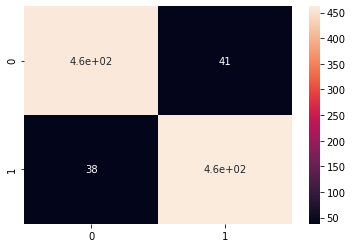

In [48]:
cm = confusion_matrix(test_dataset.classes,predictions)
sns.heatmap(cm,annot=True);

In [49]:
cnn.save("models/cnn_dog_cat_tl.h5")

/Users/wine/opt/miniconda3/envs/ds_env/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [52]:
loaded_model = load_model("models/cnn_dog_cat_tl.h5")
predictions = loaded_model.predict(test_dataset)
predictions = predictions > 0.5
accuracy_score(test_dataset.classes,predictions)

0.921

In [56]:
image = cv2.imread(f"cat_dog_2/test_set/cat/cat.3560.jpg")
image = cv2.resize(image,(128,128))
image = image/255
image = image.reshape(1,128,128,3)
result = cnn.predict(image)
result = result > 0.5
result[0][0]

False

In [55]:
train_dataset.class_indices

{'cat': 0, 'dog': 1}